In [2]:
import pinocchio
import numpy as np
import time 
import pymanopt 
from pymanopt import manifolds, optimizers, tools, core
from pymanopt.core.problem  import Problem
from pymanopt.tools.diagnostics import *
from utils import *
import networkx as nx
from scipy import optimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

import tqdm

from scipy.sparse import csr_array

LOWER = "lower_limit"
UPPER = "upper_limit"
BOUNDED = "bounded"
BELOW = "below"
ABOVE = "above"
TYPE = "type"
OBSTACLE = "obstacle"
ROBOT = "robot"
END_EFFECTOR = "end_effector"
RADIUS = "radius"
DIST = "weight"
POS = "pos"
BASE = "base"
ROOT = None
ANCHOR = "anchor"
BASE_GRAPH = "base_graph"
UNDEFINED = None


deg2rad = np.pi/180.
rad2deg = 180./np.pi

scale = 1

%load_ext autoreload
%autoreload 

In [3]:
def forwardKinematics(model,data,q,scale=1):
    pinocchio.forwardKinematics(model,data,q)
    for idx, oMi in enumerate(data.oMi):
        oMi.translation = scale*oMi.translation


def compute_rotation_axis_from_model(model,data):
    axis = []
    q0 = pinocchio.neutral(model)
    for i in range(q0.shape[0]):
        q = np.zeros((q0.shape[0]))
        q[i] = np.pi/4
        pinocchio.forwardKinematics(model,data,q)
        R_ref = data.oMi[i+1].rotation
        
        if np.abs(np.sum(R_ref@np.array([1.,0,0.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([1,0,0.])) + 1) < 10**-4:
            axis.append('x')
        elif np.abs(np.sum(R_ref@np.array([0,1,0.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([0,1,0.])) + 1) < 10**-4:
            axis.append('y')
        elif np.abs(np.sum(R_ref@np.array([0,0,1.])) - 1) < 10**-4 or np.abs(np.sum(R_ref@np.array([0,0,1.])) + 1) < 10**-4:
            axis.append('z')
        else:
            print(2)
    return axis

def trans_axis(axis,axis_length):
    if axis=='x':
        return pinocchio.SE3(np.eye(3),np.array([axis_length,0.,0]))
    elif axis=='y':
        return pinocchio.SE3(np.eye(3),np.array([0,axis_length,0.]))
    elif axis=='z':
        return pinocchio.SE3(np.eye(3),np.array([0,0.,axis_length]))


In [4]:
def create_base_graph(model,data,axis_length,base_anchor=True):

    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]

    q_init = pinocchio.neutral(model)
    
    pinocchio.forwardKinematics(model,data,q_init)
    
    robot_name = model.names[1]
    ROOT = robot_name

    base = nx.empty_graph()

    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            cur_pos, aux_cur_pos = (
                oMi.translation*scale,
                pinocchio.SE3.act(pinocchio.SE3(oMi.rotation,oMi.translation*scale),trans_z[idx-1]).translation,
            )

            #print(name,trans_z[idx-1].translation)
            
            dist = np.linalg.norm(cur_pos - aux_cur_pos)
            print(cur,aux_cur,dist,cur_pos,aux_cur_pos)
            # Add nodes for joint and edge between them
            base.add_nodes_from(
                [(cur, {POS: cur_pos}), (aux_cur, {POS: aux_cur_pos})]
            )
            base.add_edge(
                cur, aux_cur, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False}
            )
            
            # If there exists a preceeding joint, connect it to new
            if idx != 0:
                pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')
                for u in [pred, aux_pred]:
                    for v in [cur, aux_cur]:
                        dist = np.linalg.norm(
                            base.nodes[u][POS] - base.nodes[v][POS]
                        )
                        print(u,v,dist,base.nodes[u][POS],base.nodes[v][POS])
                        base.add_edge(
                            u,
                            v,
                            **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False},
                        )
        elif idx == 1:
            #print(name,oMi.translation)
            base = nx.DiGraph(
                [
                    (robot_name, "x"),
                    (robot_name, "y"),
                    (robot_name, robot_name+'_tilde'),
                    ("x", "y"),
                    ("y", robot_name+'_tilde'),
                    (robot_name+'_tilde' ,"x"),
                ]
            )
            base.add_nodes_from(
                [
                    ("x", {POS: np.array([axis_length, 0, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    ("y", {POS: np.array([0, -axis_length, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    (robot_name, {POS: oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                    (robot_name+'_tilde', {POS: trans_z[idx-1].translation + oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                ]
            )
            for u, v in base.edges():
                base[u][v][DIST] = np.linalg.norm(base.nodes[u][POS] - base.nodes[v][POS])
                base[u][v][LOWER] = base[u][v][DIST]
                base[u][v][UPPER] = base[u][v][DIST]
                base[u][v][ANCHOR] = base_anchor
                base[u][v][BOUNDED] = []

    # Set node type to robot
    nx.set_node_attributes(base, [ROBOT], TYPE)
    base.nodes[ROOT][TYPE] = [ROBOT, BASE]
    base.nodes[ROOT + '_tilde'][TYPE] = [ROBOT, BASE]


    return base


In [5]:

def norm(x):
    return x/max(np.linalg.norm(x),10**-9)

def goal_graph(model, data, G2, axis_length, position, direction = None, anchor = True,dict_alias = None):
    
    end_effector = [dict_alias[model.names[-1]]]
    if direction is not None:
        end_effector.append(model.names[-1]+'_tilde')

    list_nodes_base = ['x','y',dict_alias[model.names[1]],model.names[1]+'_tilde']

    for i, cur_end_effector in enumerate(end_effector):
        pos_end = position

        if direction is not None and i == 1:
            pos_end = pos_end + direction*axis_length
        
        G2.nodes[cur_end_effector][POS] = pos_end

        for cur_base in list_nodes_base:
            
            if not((i == 1) and (len(end_effector)==1)):
                dist = np.linalg.norm(pos_end-G2.nodes[cur_base][POS])

                G2.add_edge(
                            cur_base, cur_end_effector, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: anchor}
                        )
    if direction is not None:
        dist = axis_length
        G2.add_edge(
                            dict_alias[model.names[-1]], model.names[-1]+'_tilde', **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: anchor}
                        )
    
    if anchor:

        list_edges_anchor = []
        list_other_edges = []
        new_edge_order  = []
        A_anchor = []

        for key ,anch_ in nx.get_edge_attributes(G2,ANCHOR).items():

            if anch_:
                list_edges_anchor.append(key)
                A_anchor.append(norm(G2.nodes[key[1]][POS]- G2.nodes[key[0]][POS]))
                #print(key,' : ',norm(G.nodes[key[1]][POS]- G.nodes[key[0]][POS]))
            else:
                list_other_edges.append(key)
        new_edge_order = list_edges_anchor.copy() #.extend(list_other_edges)

        for e in list_other_edges:
            new_edge_order.append(e)

        A_anchor = np.array(A_anchor).transpose()
        
    else:

        list_edges_anchor = []
        list_other_edges = []
        A_anchor = []
        #list_other_edges = [e for e in G2.edges()]

        for key ,anch_ in nx.get_edge_attributes(G2,ANCHOR).items():

            if anch_:
                list_edges_anchor.append(key)
                A_anchor.append(norm(G2.nodes[key[1]][POS]- G2.nodes[key[0]][POS]))
                #print(key,' : ',norm(G.nodes[key[1]][POS]- G.nodes[key[0]][POS]))
            else:
                list_other_edges.append(key)

        new_edge_order = list_other_edges
        

    n = len(list_other_edges)
    n_anchor = len(list_edges_anchor)

    weight = nx.get_edge_attributes(G2, DIST)
    D = np.diag([weight[i] for i in new_edge_order])

    C = incidence_matrix_(G2,oriented=True, edgelist=new_edge_order).toarray()
    C = np.array(C)

    Y_init = np.zeros((3,n))

    for i, e in enumerate(list_other_edges):
        i = i 
        p1 = G2.nodes[e[0]][POS]
        p2 = G2.nodes[e[1]][POS]
        Y_init[:,i] = (p2-p1)/max(np.linalg.norm(p2-p1),10**-9)

    Y_init = [A_anchor,Y_init]
    return G2, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init



In [6]:
alpha_elu = 10**-5
elu = lambda x: alpha_elu*(np.exp(x/alpha_elu*(x<0))-1)*(x<0) +  x*(x>=0)
d_elu = lambda x: np.exp(x/alpha_elu*(x<0))*(x<0) + (x>=0)
dd_elu = lambda x: 1/alpha_elu*np.exp(x/alpha_elu*(x<0))*(x<0)

def simple_IK(d ,C , C_joints_limit ,D ,D_joints ,n_below, n_above, Anchor_ ,M ,max_iter,ind=None ,W=None ,Y_init=None ,
                use_rand=False, min_grad_norm = 10**-10,verbosity = 2,lambda_cons=1, constraints=True):
    if  W is None:
        W = np.eye(D.shape[0])

    if len(Anchor_)>0:
        #print('ANCHOR')
        n_anchor = Anchor_.shape[1]
        Anchor = np.zeros((d,n_anchor))
        Anchor[:3,:] = Anchor_

        if constraints:
            M = manifolds.Product([manifolds.ConstantFactory(Anchor),
                    manifolds.Oblique(d,D.shape[1]-Anchor.shape[1]),
                    manifolds.ComplementBall(d, n_below, D_joints[:n_below], 10**-8)])
        else:
            M = manifolds.Product([manifolds.ConstantFactory(Anchor),
                    manifolds.Oblique(d,D.shape[1]-Anchor.shape[1])])
                
    else:
         n_anchor = 0
         if  constraints:
            M = manifolds.Product([manifolds.Oblique(d,D.shape[1]),
                    manifolds.ComplementBall(d, n_below, D_joints[:n_below], 10**-8)])
         else:
            M = manifolds.Product([manifolds.Oblique(d,D.shape[1])])

    Q2_ = -D@(W@C.transpose()@np.linalg.pinv(C@W@C.transpose()))@C@W@D
    Q1_ = D@W@D

    Q_below = C_joints_limit[:n_below,:D.shape[0]]
    Q_above = C_joints_limit[n_below:,:D.shape[0]]
    #print('C_joints',C_joints_limit.shape)

    if constraints:
        #print('CONSTRAINTS')
        Q2 = lambda_cons**2*C_joints_limit.transpose()@C_joints_limit #np.zeros((C_joints_limit.shape[1],C_joints_limit.shape[1]))
        Q1 = np.zeros((C_joints_limit.shape[1],C_joints_limit.shape[1]))
        Q2[:Q2_.shape[0],:Q2_.shape[1]] = Q2[:Q2_.shape[0],:Q2_.shape[1]] + Q2_
        Q1[:Q1_.shape[0],:Q1_.shape[1]] = Q1_
    else:
        #print('NO CONSTRAINTS')
        Q2 = Q2_
        Q1 = Q1_

    D_below = D_joints[:n_below]**2
    D_above = D_joints[n_below:]**2
    #print(Q_below.shape)

    Y = M.random_point()
    ind = [0]
    ind.extend([y.shape[1] for y in Y])
    ind = np.array(ind)
    ind = np.cumsum(ind)
    n = len(Y)

    @pymanopt.function.numpy(M)
    def cost(*Y):
        
        Y = np.concatenate(Y,axis=1)
        if constraints:
            j =0
            #print(np.trace(lambda_cons**2*C_joints_limit.transpose()@C_joints_limit@Y.transpose()@Y),np.trace(Q1_ + Q2_@Y[:D.shape[0],:D.shape[0]].transpose()@Y[:D.shape[0],:D.shape[0]]),np.trace(Q1 + Q2@Y.transpose()@Y))
        #constr_below = - (np.linalg.norm(Q_below@Y.transpose(),axis=1)**2 - D_below)
        #constr_above = (np.linalg.norm(Q_above@Y.transpose(),axis=1)**2 - D_above)

        #constr = lambda_cons*(np.linalg.norm(np.maximum(constr_below, 0))**2 + np.linalg.norm(np.maximum(constr_above, 0))**2) 
        #constr = lambda_cons*(np.sum(np.maximum(constr_below, 0)) + np.sum(np.maximum(constr_above, 0))) 
        #constr = lambda_cons*(np.sum(elu(constr_below)) + np.sum(np.maximum(constr_above, 0))) 

        #print(constr,constr_below)
        return np.trace(Q1 + Q2@Y.transpose()@Y) #+ constr
    #print('init cost: ', cost(Y_init))
    QQ_below = np.array([q[:,np.newaxis]@q[:,np.newaxis].transpose() for q in Q_below])
    zip_below = zip(D_below,Q_below,QQ_below)
    zip_above = zip(D_above,Q_above)
    @pymanopt.function.numpy(M)
    def euclidean_gradient(*Y):
        Y = np.concatenate(Y,axis=1)
        grad = 2*Q2@Y.transpose()

        #grad_below = - sum([4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@Y.transpose() for d,q,qq in zip_below])
        #grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@Y.transpose() for d,q,qq in zip_below])
        # grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*d_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

        #if len(D_above)>0:
            #grad_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose() for d,q in zip_above])
        #else:
            # grad_above = 0
        #print('grad',np.linalg.norm(grad_above))
        #grad = grad + lambda_cons*(grad_below + grad_above)
        return [grad.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
                            
    @pymanopt.function.numpy(M)
    def euclidean_hessian(*U):
        
        Y = np.concatenate(U[:n],axis=1)
        U = np.concatenate(U[n:],axis=1)

        #hess_below = sum([-4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@U.transpose() + 8*(qq@Y.transpose())@Y@(qq)@U.transpose()*(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q,qq in zip(D_below,Q_below,QQ_below)])
        
        #hess_below = sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@U.transpose() for d,q,qq in zip(D_below,Q_below,QQ_below)])
        #hess_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*dd_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

        #if len(D_above)>0:
        #    hess_above = sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@Y@(q[:,np.newaxis]@q[:,np.newaxis].transpose())@U.transpose()*(-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q in zip(D_above,Q_above)])
        #else:
            #   hess_above = 0

        #hess_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*((q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@U)@(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose()) for d,q in zip(D_above,Q_above)])

        #hess =  lambda_cons*(hess_above + hess_below)
        
        hess = (2*Q2 )@U.transpose() #+ hess

        return [hess.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
    


    problem = Problem(manifold=M, 
                        cost=cost,
                        euclidean_gradient=euclidean_gradient, 
                        euclidean_hessian=euclidean_hessian,
                        )
    #check_gradient(problem)
    optimizer = optimizers.TrustRegions(max_iterations=max_iter,use_rand=use_rand,min_gradient_norm=min_grad_norm,verbosity=verbosity)
    

    if  Y_init is None:
        Y_init_ = M.random_point()
    elif n_anchor > 1:
        if Y_init[1].shape[0] == d:
            Y_init_ = Y_init
            
        elif Y_init[1].shape[0] < d:
            Y_init_ = np.zeros((d,Y[1].shape[1]))
            Y_init_[:Y_init[1].shape[0],:] = Y_init[1]
            Y_init_ = [Anchor, Y_init_]
            #Y_init_ = [Y_init_[1]]
            #Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            #Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())
            #Y_init_[2] = np.array([norm(y) for y in Y_init_[2].transpose()])
        else:
            U,S,V = np.linalg.svd(Y_init[1],full_matrices=False) 
            
            Y_init_ = [Anchor, U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)]
            #Y_init_ = [Y_init_]
            
            #Y_init_[2] = (C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose()

            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            #Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())
            #Y_init_[2] = np.array([norm(y) for y in Y_init_[2].transpose()])
    else:
        if Y_init[1].shape[0] == d:
            Y_init_ = Y_init
            
        elif Y_init[1].shape[0] < d:
            
            Y_init_ = np.zeros((d,Y[0].shape[1]))
            print(Y_init[0].shape,Y_init[1].shape,Y_init_.shape)
            Y_init_[:Y_init[1].shape[0],:] = Y_init[1]
            Y_init_ = [Y_init_]
            #Y_init_ = [Y_init_[1]]
            #Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[0].transpose()).transpose())
            #Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())
            #Y_init_[2] = np.array([norm(y) for y in Y_init_[2].transpose()])
        else:
            U,S,V = np.linalg.svd(Y_init[0],full_matrices=False) 
            
            Y_init_ = [U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)]
            #Y_init_ = [Y_init_]
            
            #Y_init_[2] = (C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose()

            if constraints:
                Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[0].transpose()).transpose())
   # Y_init_ = np.zeros((d,Y[0].shape[1]))
    #print(Y_init[0].shape,Y_init_[:Y_init[0].shape[0],:].shape)
   # Y_init_[:Y_init[0].shape[0],:] = Y_init[0]
   # Y_init_ = [Y_init_]
    #Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[0].transpose()).transpose())
    #[print(y.shape) for y in Y_init_]
    #[print(type(y)) for y in Y_init_]
    #print('init cost: ', cost(Y_init_))
    Y_star = optimizer.run(problem,initial_point=Y_init_, Delta_bar = 200,Delta0=0.001).point

    return Y_star, Q2+Q1


In [7]:
W = np.diag(1./np.diag(D)**2)
M=None
lambda_cons = 10**-2
n_below = len(list_edges_below)
n_above = len(list_edges_above)
print(position,direction)

Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_init_,use_rand=True,lambda_cons=lambda_cons,min_grad_norm=10**-7,constraints=False)
Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_D4,use_rand=True,lambda_cons=lambda_cons,constraints=True)


NameError: name 'D' is not defined

In [ ]:
print(new_edge_order[-5])
C_joints_limit

('lbr_iiwa_joint_6', 'lbr_iiwa_joint_6_tilde')


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.2025    ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.2045    ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.42426407,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

In [8]:
def direction_to_position(Y,C,D,data):
    X = np.linalg.pinv(C@C.transpose())@C@D@Y.transpose()
    
    X = X - X[0,:] #+ data.oMi[1].translation
    R = axis_length*np.diag((1,-1,1))@np.linalg.inv(X[1:4,:3])
    X = X@R.T + data.oMi[1].translation
    R_ = np.diag((1,-1,1))@np.linalg.inv(Y[:3,:3])
    return X, R_@Y

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix




In [9]:
def skew(x):
    """
    Creates a skew symmetric matrix from vector x
    """
    X = np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])
    return X


def joint_variables_(model,data, G, T_final, axis_length):
    """
    Finds the set of decision variables corresponding to the
    graph realization G.

    :param G: networkx.DiGraph with known vertex positions
    :param T_final: poses of end-effectors in case two final frames aligned along z
    :returns: Dictionary of joint angles
    :rtype: Dict[str, float]
    """
    tol = 1e-10
    
    T = {}
    T[model.names[1]] = data.oMi[1] #G.nodes[model.names[1]][POS]

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = [pinocchio.SE3(np.eye(3),np.array([0,0,axis_length])) for axis in model_axis]
    
    # resolve scale
    x_hat = G.nodes["x"][POS] - G.nodes[model.names[1]][POS]
    y_hat = G.nodes["y"][POS] - G.nodes[model.names[1]][POS]
    z_hat = G.nodes[model.names[1]+'_tilde'][POS] - G.nodes[model.names[1]][POS]

    # resolve rotation and translation
    x = norm(x_hat)
    y = norm(y_hat)
    z = norm(z_hat)
    R = np.vstack((x, -y, z)).T
    B = pinocchio.SE3(R, np.zeros((3,))) #G.nodes[ROOT][POS])

    #omega_z = skew(np.array([0,0,1]))
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    #omega_z = [skew(np.array([0,0,1])) for axis in model_axis]
    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z[idx-1]) # cur q xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0).translation # relative xf
            qs_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # rel q xf
            
            # predicted p and q expressed in previous frame
            p = pinocchio.SE3.act(pinocchio.SE3.inverse(B),G.nodes[cur][POS])
            qnorm = G.nodes[cur][POS] + (
                G.nodes[aux_cur][POS] - G.nodes[cur][POS]
            ) / np.linalg.norm(G.nodes[aux_cur][POS] - G.nodes[cur][POS])
            q = pinocchio.SE3.act(pinocchio.SE3.inverse(B),qnorm)
            #print(T_prev)
            ps = pinocchio.SE3.inverse(T_prev).rotation.dot(p - T_prev.translation)  # in prev. joint frame
            qs = pinocchio.SE3.inverse(T_prev).rotation.dot(q - T_prev.translation)  # in prev. joint frame
            rot = rot_axis(model_axis[idx-2])
            #theta[pred] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[pred]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            #print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta





In [10]:
def root_angle_limits(G,model,data,axis_length):
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)
    limited_joints = [] 
    i = 2
    T1 = data.oMi[1]
    base_names = ["x", "y"]
    names = [dict_alias[model.names[i]],model.names[i]+'_tilde']
    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    #T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    T_axis = [trans_axis(axis,axis_length) for axis in model_axis]

    for base_node in base_names:
        for node in names:
            T0 = pinocchio.SE3.Identity()
            T0.translation = G.nodes[base_node][POS]

            if node == dict_alias[model.names[i]]:
                T2 = data.oMi[i]
            else:
                T2 = pinocchio.SE3.act(data.oMi[i],T_axis[i])

            N = T1.rotation[0:3, 2]
            C = T1.translation + (N.dot(T2.translation - T1.translation)) * N
            r = np.linalg.norm(T2.translation - C)
            P = T0.translation
            d_max, d_min = max_min_distance_revolute(r, P, C, N)
            d = np.linalg.norm(T2.translation - T0.translation)

            if d_max == d_min:
                limit = False
            elif d == d_max:
                limit = BELOW
            elif d == d_min:
                limit = ABOVE
            else:
                limit = None

            if limit:
                T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T1),data.oMi[i])
                if node != dict_alias[model.names[i]]:
                    T_rel = pinocchio.SE3.act(T_rel,T_axis[i])

                d_limit = np.linalg.norm(
                    pinocchio.SE3.act(pinocchio.SE3.act(T1,pinocchio.SE3(Rot_z(upper_limits[0]),np.zeros((3,)))),T_rel).translation
                    - T0.translation
                )

                q0 = np.zeros((upper_limits.shape[0]))
                q0[0] = upper_limits[0]
                
                pinocchio.framesForwardKinematics(model,data,q0)

                if '_tilde' not in node:
                    d_limit = np.linalg.norm(data.oMi[1].translation-T0.translation)
                if '_tilde' in node:
                    d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[1],T_axis[i]).translation-T0.translation)

                if limit == ABOVE:
                    d_max = d_limit
                else:
                    d_min = d_limit
                limited_joints += [dict_alias[model.names[i]]]  # joint at p0 is limited
            
            G.add_edge(base_node, node)
            if d_max == d_min:
                G[base_node][node][DIST] = d_max
            G[base_node][node][BOUNDED] = [limit]
            G[base_node][node][UPPER] = d_max
            G[base_node][node][LOWER] = d_min

            

    return G

In [11]:
def set_limits(G,model,data,axis_length):
    """
    Sets known bounds on the distances between joints.
    This is induced by link length and joint limits.
    """
    #T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    T_axis = [trans_axis(axis,axis_length) for axis in model_axis]
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)#-5*deg2rad

    limited_joints = []  # joint limits that can be enforced

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for idx, (name, oMi) in enumerate(zip(model.names, data.oMi))}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 2:
            cur, prev = name, model.names[idx - 2]
            names = [
                (dict_alias[model.names[idx - 2]], dict_alias[name]),
                (dict_alias[model.names[idx - 2]],name+'_tilde'),
                (prev+'_tilde', dict_alias[name]),
                (prev+'_tilde', name+'_tilde'),
            ]


            for ids in names:
                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                #print(prev,cur,idx)
                pinocchio.framesForwardKinematics(model,data,q0)
                if '_tilde' not in ids[0] and '_tilde' not in ids[1]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = pinocchio.SE3.Identity()
                elif '_tilde' in ids[1] and '_tilde' not in ids[0]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = T_axis[idx-1]
                elif '_tilde' not in ids[1] and '_tilde' in ids[0]:
                    TT1 = T_axis[idx-3]
                    TT2 = pinocchio.SE3.Identity()
                else:
                    TT1 = T_axis[idx-3]
                    TT2 = T_axis[idx-1]

                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                pinocchio.framesForwardKinematics(model,data,q0)
                d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation)
                
                list_dist = []
                
                for theta in np.linspace(0,upper_limits[idx-2],101):
                    q0 = np.zeros((upper_limits.shape[0]))
                    q0[idx-2] = theta
                    pinocchio.framesForwardKinematics(model,data,q0)
                    list_dist.append(np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation))
                
                list_dist = np.array(list_dist)
                diff_dist = list_dist[:-1] - list_dist[1:]
                
                d_max = max(list_dist)
                d_min = min(list_dist)
                if np.max(np.abs(diff_dist))<10**-7:
                    limit = False
                    d_max = d_limit
                    d_min = d_limit
                elif sum((diff_dist > 0)) == 100:
                    limit = BELOW
                elif sum((diff_dist < 0)) == 100:
                    limit = ABOVE
                else:
                    limit=False
                    print('#############################################')


                limited_joints += [cur]

                G.add_edge(ids[0], ids[1])
                if d_max == d_min:
                    G[ids[0]][ids[1]][DIST] = d_max
                G[ids[0]][ids[1]][BOUNDED] = [limit]
                G[ids[0]][ids[1]][UPPER] = d_max
                G[ids[0]][ids[1]][LOWER] = d_min

                if limit:
                    break
    return G, limited_joints

In [12]:
def constraints_graph(model, data, G, D, new_edge_order, axis_length):
    D_tilde = {name: [val, ind] for ind, (name, val) in enumerate(zip(new_edge_order,D))}

    list_edges_below = []
    list_edges_above = []

    D_below = []
    D_above = []

    path = {}

    for n1 in G.nodes():
        for n2 in G.nodes():

            path[(n1,n2)] = []

            if n1 != n2 and ((n1,n2) not in new_edge_order):
                for p in nx.all_simple_edge_paths(G, n1, n2, 2):
                    if len(p)>1:
                        path[(n1,n2)].append(p)

    G = root_angle_limits(G,model,data,axis_length)
    G, lim_joints = set_limits(G,model,data,axis_length)

    for edge, val in nx.get_edge_attributes(G,BOUNDED).items():

        if BELOW in val:
            D_below.append(G[edge[0]][edge[1]][LOWER])
            list_edges_below.append(edge)
        if ABOVE in val and False:
            D_above.append(G[edge[0]][edge[1]][UPPER])
            list_edges_above.append(edge)

    list_edges_joints_limit = list_edges_below.copy()
    list_edges_joints_limit.extend(list_edges_above)
    
    D_joints_limit = D_below.copy()
    D_joints_limit.extend(D_above)
    
    C_joints_limit = np.zeros((len(list_edges_joints_limit),len(list_edges_joints_limit)+len(new_edge_order)))
    #print(D_tilde)
    for idx, e in enumerate(list_edges_joints_limit):
        print(e)
        p = path[e][0]
        
        C_joints_limit[idx,D_tilde[p[0]][1]] = D_tilde[p[0]][0]
        C_joints_limit[idx,D_tilde[p[1]][1]] = D_tilde[p[1]][0]

        C_joints_limit[idx,len(new_edge_order)+idx] = -1
    
    return G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above


In [13]:
def joint_variables(model,data, G, T_final, axis_length):
    """
    Finds the set of decision variables corresponding to the
    graph realization G.

    :param G: networkx.DiGraph with known vertex positions
    :param T_final: poses of end-effectors in case two final frames aligned along z
    :returns: Dictionary of joint angles
    :rtype: Dict[str, float]
    """
    tol = 1e-10
    
    T = {}
    T[model.names[1]] = data.oMi[1] #G.nodes[model.names[1]][POS]

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    #trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    #trans_z = [pinocchio.SE3(np.eye(3),np.array([0,0,axis_length])) for axis in model_axis]
    
    # resolve scale
    x_hat = G.nodes["x"][POS] - G.nodes[model.names[1]][POS]
    y_hat = G.nodes["y"][POS] - G.nodes[model.names[1]][POS]
    z_hat = G.nodes[model.names[1]+'_tilde'][POS] - G.nodes[model.names[1]][POS]

    # resolve rotation and translation
    x = norm(x_hat)
    y = norm(y_hat)
    z = norm(z_hat)
    R = np.vstack((x, -y, z)).T
    B = pinocchio.SE3(R, np.zeros((3,))) #G.nodes[ROOT][POS])

    #omega_z = skew(np.array([0,0,1]))
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    #omega_z = [skew(np.array([0,0,1])) for axis in model_axis]
    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z[idx-1]) # cur q xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0).translation # relative xf
            qs_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # rel q xf
            
            # predicted p and q expressed in previous frame
            p = pinocchio.SE3.act(pinocchio.SE3.inverse(B),G.nodes[cur][POS])
            qnorm = G.nodes[cur][POS] + (
                G.nodes[aux_cur][POS] - G.nodes[cur][POS]
            ) / np.linalg.norm(G.nodes[aux_cur][POS] - G.nodes[cur][POS])
            q = pinocchio.SE3.act(pinocchio.SE3.inverse(B),qnorm)
            #print(T_prev)
            ps = pinocchio.SE3.inverse(T_prev).rotation.dot(p - T_prev.translation)  # in prev. joint frame
            qs = pinocchio.SE3.inverse(T_prev).rotation.dot(q - T_prev.translation)  # in prev. joint frame
            rot = rot_axis(model_axis[idx-2])
            
            theta[pred] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            #theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            
            #print(qs.dot(skew(qs_0)).dot(qs), qs_0.dot(qs))
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[pred]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            print(idx, ps_0, ps, )
            #print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta

def trans_axis(axis,axis_length):
    if axis=='x':
        return pinocchio.SE3(np.eye(3),np.array([axis_length,0.,0]))
    elif axis=='y':
        return pinocchio.SE3(np.eye(3),np.array([0,axis_length,0.]))
    elif axis=='z':
        return pinocchio.SE3(np.eye(3),np.array([0,0.,axis_length]))
    

def joint_variables(model,data, Y, new_edge_order, T_final, axis_length, dict_alias):   
    
    T = {}
    T[1] = data.oMi[1] 

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {idx: oMi for idx, (name, oMi) in enumerate(zip(model.names, data.oMi))}
    #print(T_zero)
    trans_z = [trans_axis(axis,axis_length) for axis in model_axis]
    omega_z = [skew(trans_axis(axis,1).translation) for axis in model_axis]
    
    theta = np.zeros((len(model.names)-1,))
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (dict_alias[name], dict_alias[name+'_tilde'])
            pred, aux_pred = (dict_alias[model.names[idx-1]], dict_alias[model.names[idx-1]+'_tilde'])

            T_prev = T[idx-1]
            
            T_prev_0 = T_zero[idx-1] # previous p xf at 0
            #print(idx,T_prev_0,pred,cur)
            T_0 = T_zero[idx] # cur p xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            T_0_q = pinocchio.SE3.act(T_zero[idx],trans_z[idx-1]) # cur q xf at 0
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # relative xf
            ps_0 = norm(ps_0)
            
            #print((pred,aux_cur))
            ind_ps = new_edge_order.index((pred,aux_cur))
            ps = T[idx-1].rotation.transpose()@Y[:,ind_ps]
            #if idx > 2:
                #print(T[pred].rotation.transpose()@Y[:,new_edge_order.index((model.names[idx-2],aux_pred))])
            
            theta[idx-2] = np.arctan2(-ps_0.dot(omega_z[idx-2]).dot(ps), ps_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(ps))
            #theta[pred] = np.arctan2(-qs_0.dot(omega_z[idx-2]).dot(qs), qs_0.dot(omega_z[idx-2].dot(omega_z[idx-2].T)).dot(qs))
            rot = rot_axis(model_axis[idx-2])
            #print(qs.dot(skew(qs_0)).dot(qs), qs_0.dot(qs))
            #rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            rot_axis_z = pinocchio.SE3(rot(theta[idx-2]),np.zeros((3,)))
            T[idx] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)
            #print(T[cur].rotation.transpose()@Y[:,ind_ps])
            #print(idx,pred,aux_cur, ps_0, ps)
            #print(pred,cur,idx,trans_z[idx-2].translation,theta[pred]*rad2deg,ps,ps_0)
    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta


In [14]:
def contract_graph(G):
    list_contraction = []
    
    dict_alias = {node: node for i,node in enumerate(G.nodes())}

    for i, e in enumerate(G.edges()):
        dist = np.linalg.norm(G.nodes[e[0]][POS] - G.nodes[e[1]][POS])
        if dist == 0:
            list_contraction.append(e)
            dict_alias[e[1]] = e[0]
    
    for e in list_contraction:
        G = nx.contracted_edge(G,e,self_loops=False)

    return G, dict_alias


In [21]:
axis_length = 0.3*scale
urdf_filename= 'GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf' #"GraphIK/graphik/robots/urdfs/ur10_mod.urdf" #"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"

#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
#"GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_lwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'

model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()

model_axis=compute_rotation_axis_from_model(model,data)
print(model_axis)
G = create_base_graph(model,data,axis_length,base_anchor=True)
G, dict_alias = contract_graph(G)
q0 = np.array([30,-120,170,-40,90,0,0])*np.pi/180
#q0 = np.array([3,2,-4.3,0,2,-1])*np.pi/180
q0 = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q0)
position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
direction = None# data.oMi[-1].rotation@np.array([0,0,1])

print(position, direction)
ROOT = model.names[1]

G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                position, direction = direction, anchor = True,dict_alias=dict_alias)

G1, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above = constraints_graph(model, data, G1, np.diag(D), new_edge_order, axis_length)

n_below = len(list_edges_below)
#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
#Y_init_ = [Y_init_[1]]
#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[1].transpose()).transpose())
Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())


['z', 'z', 'z', 'z', 'z', 'z', 'z']
lbr_iiwa_joint_2 lbr_iiwa_joint_2_tilde 0.3 [0.   0.   0.36] [-6.20469321e-14  3.00000000e-01  3.60000000e-01]
lbr_iiwa_joint_1 lbr_iiwa_joint_2 0.20249999999999999 [0.     0.     0.1575] [0.   0.   0.36]
lbr_iiwa_joint_1 lbr_iiwa_joint_2_tilde 0.3619478553612315 [0.     0.     0.1575] [-6.20469321e-14  3.00000000e-01  3.60000000e-01]
lbr_iiwa_joint_1_tilde lbr_iiwa_joint_2 0.09750000000000003 [0.     0.     0.4575] [0.   0.   0.36]
lbr_iiwa_joint_1_tilde lbr_iiwa_joint_2_tilde 0.31544611267174233 [0.     0.     0.4575] [-6.20469321e-14  3.00000000e-01  3.60000000e-01]
lbr_iiwa_joint_3 lbr_iiwa_joint_3_tilde 0.30000000000000004 [ 2.07103964e-25 -1.00133990e-12  5.64500000e-01] [ 6.20469321e-14 -1.00130659e-12  8.64500000e-01]
lbr_iiwa_joint_2 lbr_iiwa_joint_3 0.20450000000000002 [0.   0.   0.36] [ 2.07103964e-25 -1.00133990e-12  5.64500000e-01]
lbr_iiwa_joint_2 lbr_iiwa_joint_3_tilde 0.5045000000000001 [0.   0.   0.36] [ 6.20469321e-14 -1.00130659e-1

In [22]:
W = np.diag(1./np.diag(D)**2)
M=None
lambda_cons = 10**0
n_below = len(list_edges_below)
n_above = len(list_edges_above)
print(position,direction)

Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_init_,use_rand=True,lambda_cons=lambda_cons,min_grad_norm=10**-7,constraints=True)
Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_D4,use_rand=True,lambda_cons=lambda_cons,constraints=True)


U,S,V = np.linalg.svd(Y_D4[0],full_matrices=False)
print(S)

[-0.26753425  0.13602661  1.15218023] None
Optimizing...
                                            f: +6.051691e-01   |grad|: 1.172044e+00
acc TR+   k:     1     num_inner:     0     f: +6.039977e-01   |grad|: 1.170800e+00   exceeded trust region
acc TR+   k:     2     num_inner:     0     f: +6.016586e-01   |grad|: 1.168308e+00   exceeded trust region
acc TR+   k:     3     num_inner:     0     f: +5.969954e-01   |grad|: 1.163319e+00   exceeded trust region
acc TR+   k:     4     num_inner:     0     f: +5.877289e-01   |grad|: 1.153313e+00   exceeded trust region
 +++ Detected many consecutive TR+ (radius increases).
 +++ Consider increasing options.Delta_bar by an order of magnitude.
 +++ Current values: Delta_bar = 200 and Delta0 = 0.001.
acc TR+   k:     5     num_inner:     0     f: +5.694372e-01   |grad|: 1.133187e+00   exceeded trust region
acc TR+   k:     6     num_inner:     0     f: +5.338283e-01   |grad|: 1.092502e+00   exceeded trust region
acc TR+   k:     7     num_inn

In [17]:
d=3
Y_star =  Y_D3[:2]#U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)
e1 = np.array([1,0,0])
e2 = np.array([0,1,0])
e3 = np.array([0,0,1])

if len(Y_star) == 2:
    X, Y = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
else:
    X, Y = direction_to_position(Y_star,C,D,data)

print(X)
print(np.linalg.norm(X[-2,:]-position))
if direction is not None:
    print(np.linalg.norm((X[-1,:]-X[-2,:])/axis_length-direction))
print(position)
print(model_axis)

#for idx,node in enumerate(G1.nodes()):
 #   G1.nodes[node][POS] = X[idx,:]


theta = joint_variables(model,data, Y, new_edge_order, data.oMi[-1], axis_length,dict_alias) #joint_variables(model,data, G1, data.oMi[-1], axis_length)
print(theta*rad2deg)
theta = np.clip(theta,model.lowerPositionLimit,model.upperPositionLimit)
#theta = np.array([theta_ for key, theta_ in theta.items()])
#theta[2] = -theta[2] 
#theta[3] = -90*deg2rad+theta[3]
#theta[4] = -180*deg2rad+theta[4]
pinocchio.forwardKinematics(model,data,theta)
print(np.linalg.norm(position-data.oMi[-1].translation))
print('pos effective',data.oMi[-1].translation)
if direction is not None:
    print(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))
print(model.upperPositionLimit*rad2deg,model.lowerPositionLimit*rad2deg)
print(q0*rad2deg)
print((theta*rad2deg).tolist())
print(ll)




[[ 0.00000000e+00  0.00000000e+00  1.57500000e-01]
 [ 3.00001407e-01  4.57651816e-04  1.59160973e-01]
 [-4.61470653e-04 -3.00005226e-01  1.54833898e-01]
 [-1.66717631e-03  2.65031762e-03  4.57508394e-01]
 [-1.40024980e-02  5.35852718e-03  3.66626386e-01]
 [-1.74698686e-01  2.56623232e-01  3.36272288e-01]
 [ 1.38618541e-02  4.68974470e-02  5.75111525e-01]
 [-6.18396625e-03  1.70203155e-01  8.59072616e-01]
 [-9.61555774e-03  1.42132255e-01  7.76655175e-01]
 [ 2.50798175e-01  9.60441727e-03  8.62838494e-01]
 [ 8.70667036e-02  2.92028390e-01  7.17748995e-01]
 [ 2.44353124e-01  5.43753279e-01  6.72295191e-01]
 [ 2.01743995e-01  4.71628595e-01  6.45496558e-01]
 [-5.08982033e-02  6.33053579e-01  6.53068461e-01]
 [ 1.52066681e-01  4.11450705e-01  6.26824078e-01]
 [ 2.97472626e-03  1.61168002e-01  7.24893104e-01]]
0.004998721700769653
[0.15270706 0.41503984 0.62340425]
['z', 'z', 'z', 'z', 'z', 'z', 'z']
[  34.4777941    11.10879699   34.03592839  -93.03301639   -8.95733849
 -178.28752143    0.

NameError: name 'll' is not defined

In [31]:
count_success = 0
success_range = 0

fail_range = []
err_pos = []
err_or = []
fail = []
scale = 1
lambda_cons = 1*10**-2
axis_length = 0.3*scale
urdf_filename="GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
#"GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'
model = 0
data = 0
model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()
model_axis=compute_rotation_axis_from_model(model,data)
print(model_axis)
anchor = False
base_anchor = False

G = create_base_graph(model,data,axis_length,base_anchor=base_anchor)
G, dict_alias = contract_graph(G)

q = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q)
position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
direction = None#data.oMi[-1].rotation@np.array([0,0,1])

#print(position, direction)

G, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                position, direction = direction, anchor = anchor,dict_alias=dict_alias)
G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below,list_edges_above = constraints_graph(model, data, G, np.diag(D), new_edge_order, axis_length)  


#Y_init_.append((C_joints_limit[:,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())

#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@np.concatenate(Y_init_,axis=1).transpose()).transpose())
#Y_init_.append((C_joints_limit[:n_below,:D.shape[0]]@Y_init_[1].transpose()).transpose())

#Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())


n_below = len(list_edges_below)
#Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@Y_init_[1].transpose()).transpose())
#Y_init_.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_init_[:2],axis=1).transpose()).transpose())

Y_D3 = Y_init_
q = pinocchio.randomConfiguration(model)
q = np.array([90,-90,0,90,0,50,0])*np.pi/180

for i in tqdm.tqdm(range(200)):
    #print('#####')
    q = q + np.random.normal(size=(q.shape[0],))*3.*deg2rad
    q = np.clip(q,model.lowerPositionLimit,model.upperPositionLimit)
    #Y_D3 = Y_init_.copy()
   # print('cost test:', cost(Y_D3))
    #q = pinocchio.randomConfiguration(model)
    pinocchio.framesForwardKinematics(model,data,q)
    position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
    direction = None#data.oMi[-1].rotation@np.array([0,0,1])

    #print(position, direction)

    G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                 position, direction = direction, anchor = anchor,dict_alias=dict_alias)
    

    W = np.diag(1./np.diag(D)**2)#np.diag(np.concatenate([np.ones(n_anchor),np.ones(n)]))
    M=None
    
    n_below = len(list_edges_below)
    n_above = len(list_edges_above)
    lambda_cons = 10**0
    #Y_D5,Q2 = simple_IK(5,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=50,ind=None,W=W,Y_init=Y_D3,use_rand=True,min_grad_norm=10**-7,verbosity = 0)
    ##print('----')
    #lambda_cons = 10**-1
    Y_D4,Q2 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,
                        Y_init=Y_D3,use_rand=True,min_grad_norm=10**-8,verbosity = 0,constraints=False)
    #print('----')
    
    Y_D4.append((C_joints_limit[n_below:,:D.shape[0]]@np.concatenate(Y_D4[:2],axis=1).transpose()).transpose())

#    Y_D4.append((C_joints_limit[n_below:,:D.shape[0]]@Y_D4[0].transpose()).transpose())
    Y_D3,Q2 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1500,ind=None,W=W,
                        Y_init=Y_D4,use_rand=True,min_grad_norm=10**-9,verbosity = 2,constraints=True)
    
    if n_anchor > 2:
        Y_star = Y_D3[:2]
    else:
        Y_star = Y_D3[0]


    if len(Y_star) == 2:
        X, Y = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
    else:
        X, Y = direction_to_position(Y_star,C,D,data)
    
    for idx,node in enumerate(G1.nodes()):
        G1 .nodes[node][POS] = X[idx,:]

    theta = joint_variables(model,data, Y, new_edge_order, data.oMi[-1], axis_length,dict_alias)  #joint_variables(model,data, G1, data.oMi[-1], axis_length)
    theta = np.clip(theta,model.lowerPositionLimit,model.upperPositionLimit)
    #theta = np.array([theta_ for key, theta_ in theta.items()])
    pinocchio.forwardKinematics(model,data,theta)
    err_pos.append(np.linalg.norm(position-data.oMi[-1].translation))
    
    if direction is not None:
        err_or.append(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))

    if not (False in (theta>=model.lowerPositionLimit[:len(model.upperPositionLimit)]).tolist() or False in (theta<=model.upperPositionLimit[:len(model.upperPositionLimit)]).tolist()) :
        success_range = success_range + 1
        fail.append(False)
    else:
        fail.append(True)
        fail_range.append([theta,position,direction,q,X])
        break


['z', 'z', 'z', 'z', 'z', 'z', 'z']
lbr_iiwa_joint_2 lbr_iiwa_joint_2_tilde 0.3 [0.   0.   0.36] [-6.20469321e-14  3.00000000e-01  3.60000000e-01]
lbr_iiwa_joint_1 lbr_iiwa_joint_2 0.20249999999999999 [0.     0.     0.1575] [0.   0.   0.36]
lbr_iiwa_joint_1 lbr_iiwa_joint_2_tilde 0.3619478553612315 [0.     0.     0.1575] [-6.20469321e-14  3.00000000e-01  3.60000000e-01]
lbr_iiwa_joint_1_tilde lbr_iiwa_joint_2 0.09750000000000003 [0.     0.     0.4575] [0.   0.   0.36]
lbr_iiwa_joint_1_tilde lbr_iiwa_joint_2_tilde 0.31544611267174233 [0.     0.     0.4575] [-6.20469321e-14  3.00000000e-01  3.60000000e-01]
lbr_iiwa_joint_3 lbr_iiwa_joint_3_tilde 0.30000000000000004 [ 2.07103964e-25 -1.00133990e-12  5.64500000e-01] [ 6.20469321e-14 -1.00130659e-12  8.64500000e-01]
lbr_iiwa_joint_2 lbr_iiwa_joint_3 0.20450000000000002 [0.   0.   0.36] [ 2.07103964e-25 -1.00133990e-12  5.64500000e-01]
lbr_iiwa_joint_2 lbr_iiwa_joint_3_tilde 0.5045000000000001 [0.   0.   0.36] [ 6.20469321e-14 -1.00130659e-1

  0%|          | 0/200 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
print(max(err_pos),max(err_pos),success_range)
succ = 0
for o,p,f in zip(err_or,err_pos, fail):
    if np.abs(o)<10**-2 and np.abs(p)<10**-2 and not f:
        succ = succ +1 
print('Number of successful IK',succ)
print(theta*rad2deg)
model.upperPositionLimit*rad2deg



0.6987430197982054 0.6987430197982054 55
Number of successful IK 0
[-27.50025581 120.          75.45232019  93.81584148   8.0797471
  51.59786255   0.        ]


array([170., 120., 170., 120., 170., 120., 175.])

array([-170., -120., -170., -120., -170., -120., -175.])

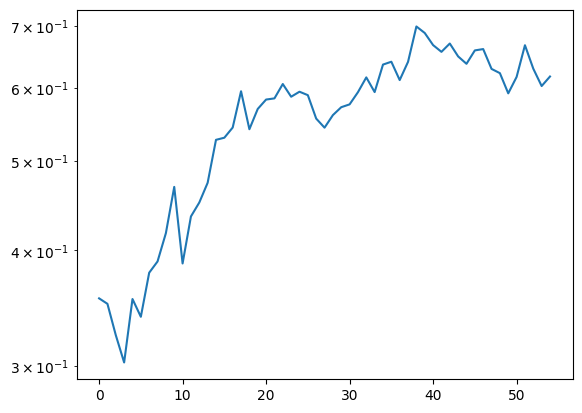

In [ ]:
plt.semilogy(err_pos)
for dd in fail_range:
    print(dd[0]*rad2deg, dd[3]*rad2deg)
    print(dd[1],dd[2])
    print('##############')
model.lowerPositionLimit*rad2deg

In [14]:
import numpy as np
np.arccos(0.99985)*180/3.14

0.9929077790071059

In [ ]:
print(new_edge_order[20])
print(list_edges_below)

('lbr_iiwa_joint_2', 'lbr_iiwa_joint_3')
[('lbr_iiwa_joint_1', 'lbr_iiwa_joint_3'), ('y', 'lbr_iiwa_joint_2_tilde'), ('lbr_iiwa_joint_2_tilde', 'lbr_iiwa_joint_4_tilde'), ('lbr_iiwa_joint_3', 'lbr_iiwa_joint_5'), ('lbr_iiwa_joint_4_tilde', 'lbr_iiwa_joint_6_tilde'), ('lbr_iiwa_joint_5', 'lbr_iiwa_joint_7')]
